
## SUPPLEMENTARY INFORMATION (Forward osmosis model)

### Millifluidic device for forward osmosis: Performance assessment of a novel membrane by Aka Doche1, Christel Causserand1, Yannick Hallez1, Pierre Roblin1, Gian-Vincent Dizon2, Antoine Venault2, Chung-Jung Chou2, Yung Chang2, Patrice Bacchin1  



      C       JwFF  JwFF_err        JsFF   JsFF_err       JwFD  JwFD_err  \
0    50   2.610000  0.420000    3.860000   0.460000   2.239720  1.131525   
1   200   4.397784  0.917663    7.420000   3.080000   6.330000  0.500000   
2   500  12.061826  1.123748   35.006231   4.230509  15.584719  1.792554   
3  1000  14.225722  0.314961   52.190000  15.796000  21.096718  1.158619   
4  1500  18.174395  1.360941  159.000213   9.192524  22.362205  0.997375   
5  2000  23.884514  3.464567  252.614610  33.112161  30.159456  4.005682   

         JsFD   JsFD_err  
0   11.518563   6.071010  
1   11.890000   3.060000  
2   33.510000   6.360000  
3   61.360000  14.520772  
4  151.598396  86.854098  
5  294.421572  70.589964  
Cross floW velocity in feed compartment is  6.060E-02 m/s
Cross floW velocity in DS compartment is  4.545E-02 m/s
3.0555555555555556e-12
hydraulic diameter of the DS side 2.000E-03
hydraulic diameter of the FS side 1.875E-03
The reynold number in the draw solution compartment (

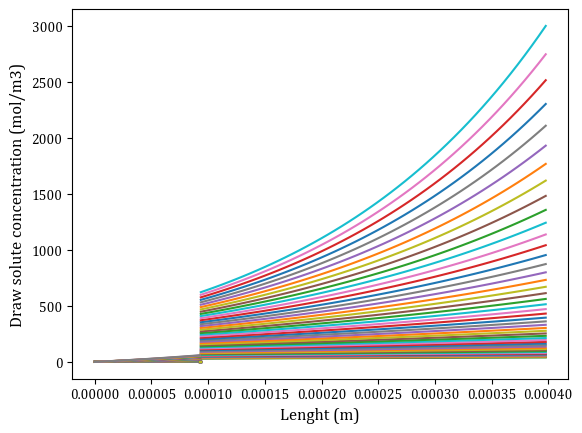

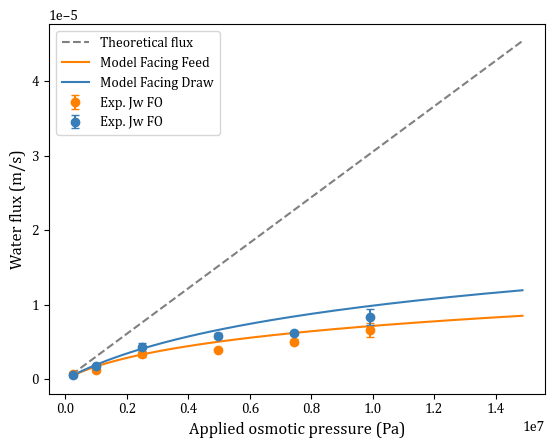

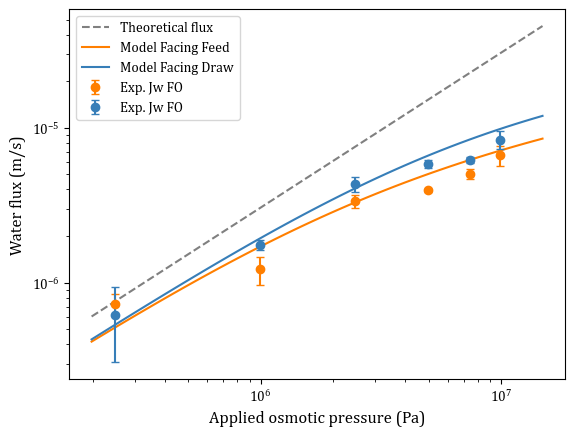

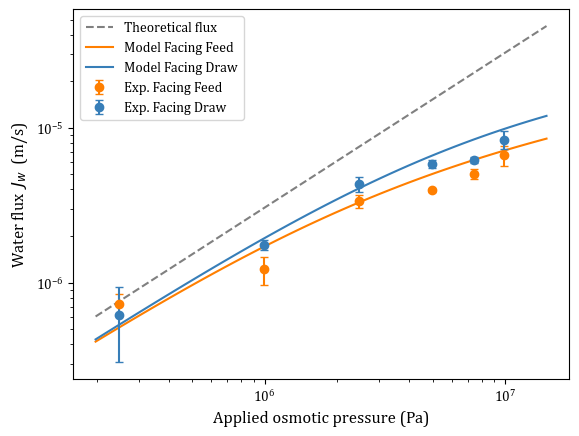

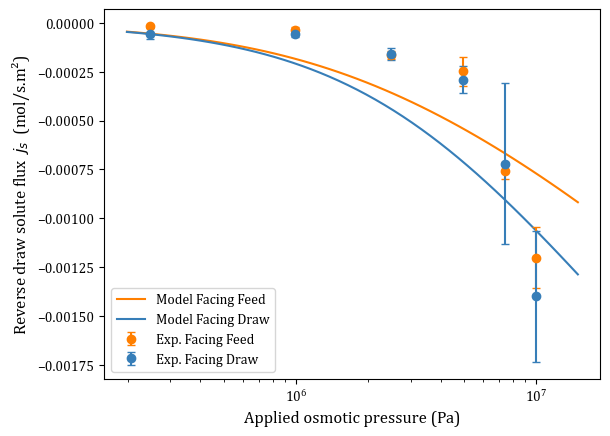

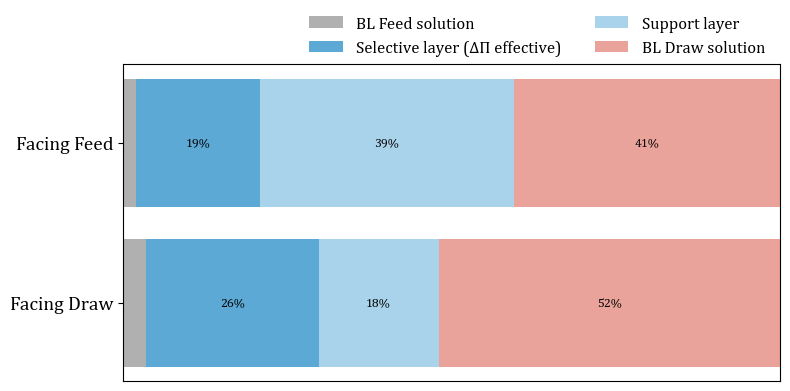

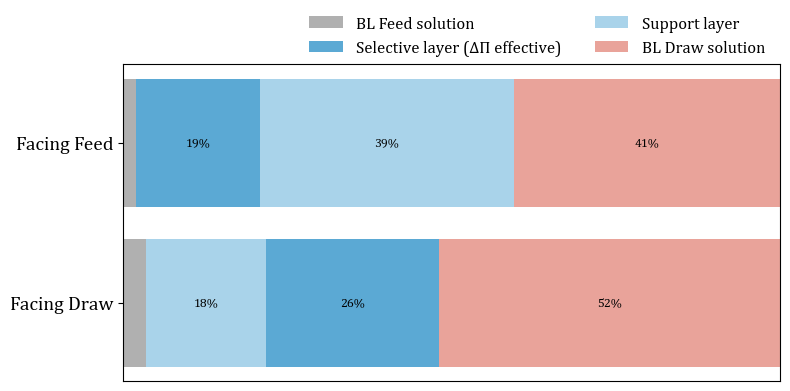

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import fsolve
import pandas  
import matplotlib.font_manager as fm 

font_path = r"C:\Windows\Fonts\cambria.ttc"
prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = prop.get_name()

#Experimental data #Add the .xlsx file of the experimental results 
data = pandas.read_excel("20250825DATA.xlsx") #Unités Jw (L/hm²) Js (g/hm²)
print(data)

R=8.314
Q_DS= 9.09*1e-7 #Put a value of the tangential flowrate in DS (m3/s) 
Q_FS= 9.09*1e-7 #Put a value of the tangential flowrate in FS (m3/s)

#Cell dimension Draw solution compartment  
e_DS= 0.002 #Module fluid circulation thickness m
l_DS= 0.002 #Module width m
S_DS=e_DS*l_DS #m²

#Cell dimension feed compartment 
e_FS= 0.001 #Module fluid circulation thickness m
l_FS= 0.015  #Module width m
S_FS=e_FS*l_FS #m²

##solution
T=298 #Temperature K 
rho=1000 #density kg.m-3
mu=0.001 #viscosity Pa.s
D=1.79e-9 #Diffusion coefficient m²/s
M=58.44 #Molar weight g/mol

c_Fb=1e-6 #concentration of drawing solute in plasma side (should not be 0 for calc.) mol/m3 1e-6 
c_Db_min= 40 #mol/m3
c_Db= 3000  #mol/m3 Concentration of drawing solution (max)
nbc=50 #number of  taken for calculations 50

v_FS=Q_FS/S_FS #m/s
v_DS=(Q_DS/5)/S_DS #m/s

print ('Cross floW velocity in feed compartment is ',"%.3E"% v_FS, 'm/s')
print ('Cross floW velocity in DS compartment is ',"%.3E"% v_DS, 'm/s')

#Membrane
K=1e-05  #Membrane Partition coefficient / Initialize then change the value to the optimization  
deltaSL=200*1e-6 #Membrane support layer thikness m
deltaM=0.7e-6 #membrane selective layer thickness m 
kM= 1.630959e-01 

Lp= 1.1 #permeability L/(h.m2.bar) 
Lp=Lp*1e-3/(3600*1e5) # permeability m.s-1.Pa-1
print(Lp)

#Hydrodynamic
d_DS=4*S_DS/(2*(l_DS+e_DS)) #hydraulic diameter of the DS side m
d_FS=4*S_FS/(2*(l_FS+e_FS)) #hydraulic diameter of the PL side m

print('hydraulic diameter of the DS side', "%.3E"%d_DS)
print('hydraulic diameter of the FS side',"%.3E"%d_FS )

#Calculate the Reynolds number of add it manually 

#Re_DS=100 #Reynolds number in the DS side
#Re_FS=100#Reynolds number in the FS side
Re_DS=(rho*v_DS*d_DS)/mu
Re_FS=(rho*v_FS*d_FS)/mu 

print ('The reynold number in the draw solution compartment (DS) is ',round(Re_DS,0))
print ('The reynold number in the feed solution compartment (FS) is', round(Re_FS,0))


deltaP= 0 #applied pressure (Pa) 
L=0.085 #channel length m (LONGEUR 8.5 cm) length rectangular part 0.065

#mass transfer coefficient estimated from Leveque equation
Sc=mu/(rho*D)
Sh_DS=1.85*(Re_DS*Sc*d_DS/L)**0.33 #For laminar flow 
Sh_FS=1.85*(Re_FS*Sc*d_FS/L)**0.33  #For laminar flow 

k_DS=Sh_DS*D/d_DS
k_FS=Sh_FS*D/d_FS
deltaDS=D/k_DS #Boundary layer DS 
deltaFS=D/k_FS #Boundary layer feed
print('Boundary layers thickness FS: {:.2e} m DS : {:.2e} m'.format(deltaFS, deltaDS))

#function to calculate the osmotic pressure
def Pi(c):
    return 2*c*R*T

#function to calculate the mass flux
def jf(J,c_Db):
    PeDS=J/k_DS
    PeM=J/kM
    PeFS=J/k_FS
    Den=np.exp(PeFS)-1+(np.exp(PeM)-1)/(K*np.exp(PeM))+(np.exp(PeDS)-1)/(np.exp(PeDS)*np.exp(PeM))
    return J*(c_Fb*np.exp(PeFS)-c_Db*np.exp(-PeDS)*np.exp(-PeM))/Den

#function to have egal to zero to finc the permeate flux
def cible(J,c_Db):
    PeDS=J/k_DS
    PeM=J/kM
    PeFS=J/k_FS
    j=jf(J,c_Db)
    c_Fi=(c_Fb-j/J)*np.exp(PeFS)+j/J
    c_Di=(c_Db-j/J)*np.exp(-PeDS)+j/J
    return J*1e10-1e10*(deltaP-Pi(c_Fi)+Pi(c_Di))*Lp 


#Variable initialization 
c_Db_tab = np.logspace(np.log10(c_Db_min), np.log10(c_Db), nbc)
j_FF=np.zeros(nbc) #Reverse draw solute flux in FF (mol.s-1.m-2)
J_FF=np.zeros(nbc) # Water flux in FF (m/s)
j_FD=np.zeros(nbc) #Reverse draw solute flux in FD (mol.s-1.m-2)
J_FD=np.zeros(nbc) # Water flux in FD (m/s)
J_theo= np.zeros(nbc) # Expected theoretical flux with the applied osmotic pressure (m/s)
J0=np.zeros(nbc) # Water flux without concentration polarization (m/s)

# loop to find J for different value of drawing concentration, c_Fb 
# FACING FEED CONFIGURATION 

k_DS=1/(1/k_DS+deltaSL/D)

fig, ax = plt.subplots()
for i in range(nbc):
    c_Db=c_Db_tab[i]
    
    #Expected theoretical flux with the applied osmotic pressure 
    J_theo[i]=(deltaP-(Pi(c_Fb)-Pi(c_Db)))*Lp
    
    #Water fluxwith polarization
    J_FF[i]=fsolve(cible, J_theo[i]/10000, args=c_Db)[0]  #il faut réduire l'init pour converger à haute cc 
    
    #Mass flux of drawing solute through the membrane
    j_FF[i]=jf(J_FF[i],c_Db)
      
    PeDS=J_FF[i]/k_DS
    PeM=J_FF[i]/kM
    PeFS=J_FF[i]/k_FS
    print('Peclet FS',PeFS,'M',PeM,'DS',PeDS)
    
    #intermediate concentration
    c_Di=(c_Db-j_FF[i]/J_FF[i])*np.exp(-PeDS)+j_FF[i]/J_FF[i]
    c_Dis=(c_Db-j_FF[i]/J_FF[i])*np.exp(-J_FF[i]*(1/k_DS-deltaSL/D))+j_FF[i]/J_FF[i]
    c_MD=c_Di*K
    c_MF=(c_MD-j_FF[i]/J_FF[i])*np.exp(-PeM)+j_FF[i]/J_FF[i]
    c_Fi=c_MF/K
    c_Fb=(c_Fi-j_FF[i]/J_FF[i])*np.exp(-PeFS)+j_FF[i]/J_FF[i]
    #print(c_Db,c_Di,c_MD,c_MF,c_Fi,c_Fb)

    datacFF=np.array([Pi(c_Fi)-Pi(c_Fb),Pi(c_Di)-Pi(c_Fi),Pi(c_Dis)-Pi(c_Di),Pi(c_Db)-Pi(c_Dis)])
    

    #plot of concentration profile
    xFS=np.linspace(0,deltaFS,50)
    plt.plot(xFS, (c_Fb-j_FF[i]/J_FF[i])*np.exp(PeFS*xFS/deltaFS)+j_FF[i]/J_FF[i])
    xM=np.linspace(0,deltaM,50)
    plt.plot(xM+deltaFS, (c_MF-j_FF[i]/J_FF[i])*np.exp(PeM*xM/deltaM)+j_FF[i]/J_FF[i])
    xDS=np.linspace(0,deltaDS+deltaSL,50)
    plt.plot(xDS+deltaM+deltaFS, (c_Di-j_FF[i]/J_FF[i])*np.exp(PeDS*xDS/(deltaDS+deltaSL))+j_FF[i]/J_FF[i])
    if abs(c_Db-((c_Di-j_FF[i]/J_FF[i])*np.exp(PeDS)+j_FF[i]/J_FF[i]))>0.001 :
        print ('Probleme')
    J0[i]=(deltaP-(Pi(c_Fb)-Pi(c_Db)))*Lp
    plt.ylabel('Draw solute concentration (mol/m3)',fontsize=12)
    plt.xlabel('Lenght (m)',fontsize=12)    
        
## FACING DRAW CONFIGURATION 

k_DS=Sh_DS*D/d_DS
k_FS=1/(1/k_FS+deltaSL/D)

fig, ax = plt.subplots()
for i in range(nbc):
    c_Db=c_Db_tab[i]
    #Expected theoretical flux with the applied osmotic pressure 
    J_theo[i]=(deltaP-(Pi(c_Fb)-Pi(c_Db)))*Lp
    
    #Water flux with polarization
    J_FD[i]=fsolve(cible, J_theo[i]/10000, args=c_Db)[0]  #Reduce the initial value to converge when cc is  
    
    #mass flux of drawing solute through the membrane
    j_FD[i]=jf(J_FD[i],c_Db)
    PeDS=J_FD[i]/k_DS
    PeM=J_FD[i]/kM
    PeFS=J_FD[i]/k_FS
    print('Peclet FS ',PeFS, ' M ', PeM, ' DS ', PeDS)
    #intermediate concentration
    
    c_Di=(c_Db-j_FD[i]/J_FD[i])*np.exp(-PeDS)+j_FD[i]/J_FD[i]
    c_MD=c_Di*K
    c_MF=(c_MD-j_FD[i]/J_FD[i])*np.exp(-PeM)+j_FD[i]/J_FD[i]
    c_Fi=c_MF/K
    c_Fb=(c_Fi-j_FD[i]/J_FD[i])*np.exp(-PeFS)+j_FD[i]/J_FD[i]
    c_Fis=(c_Fi-j_FD[i]/J_FF[i])*np.exp(-J_FD[i]*(1/k_FS-deltaFS/D))+j_FD[i]/J_FD[i] #c at Porous layer/ Plasma interface
    #print(c_Db,c_Di,c_MD,c_MF,c_Fi,c_Fb)
    J0[i]=(deltaP-(Pi(c_Fb)-Pi(c_Db)))*Lp
    datacFD=np.array([Pi(c_Fis)-Pi(c_Fb),Pi(c_Di)-Pi(c_Fi),Pi(c_Fi)-Pi(c_Fis),Pi(c_Db)-Pi(c_Di)])


plt.plot(Pi(c_Db_tab)-Pi(c_Fb), J0, color='gray', linestyle='--', label='Theoretical flux')
plt.plot(Pi(c_Db_tab)-Pi(c_Fb), J_FF, color='#FF7F00', label='Model Facing Feed')
plt.plot(Pi(c_Db_tab)-Pi(c_Fb), J_FD, color='#377EB8', label='Model Facing Draw')

plt.errorbar(Pi(data['C'])-Pi(c_Fb), data['JwFF']*1e-3/3600,yerr=data['JwFF_err']*1e-3/3600, marker= 'o',color='#FF7F00', linestyle='none',label='Exp. Jw FO',capsize=3)#m/s
plt.errorbar(Pi(data['C'])-Pi(c_Fb), data['JwFD']*1e-3/3600,yerr=data['JwFD_err']*1e-3/3600, marker='o',color='#377EB8', linestyle='none',label='Exp. Jw FO',capsize=3)#m/s
A=2*c_Db_tab*R*T*Lp
plt.ylabel('Water flux (m/s)',fontsize=12)
plt.xlabel('Applied osmotic pressure (Pa)',fontsize=12)
plt.legend()
plt.show()

plt.loglog(Pi(c_Db_tab)-Pi(c_Fb), J0, color='gray', linestyle='--', label='Theoretical flux')
plt.loglog(Pi(c_Db_tab)-Pi(c_Fb), J_FF, color='#FF7F00', label='Model Facing Feed')
plt.loglog(Pi(c_Db_tab)-Pi(c_Fb), J_FD, color='#377EB8', label='Model Facing Draw')
plt.errorbar(Pi(data['C'])-Pi(c_Fb), data['JwFF']*1e-3/3600,yerr=data['JwFF_err']*1e-3/3600, marker= 'o',color='#FF7F00', linestyle='none',label='Exp. Jw FO',capsize=3)#m/s
plt.errorbar(Pi(data['C'])-Pi(c_Fb), data['JwFD']*1e-3/3600,yerr=data['JwFD_err']*1e-3/3600, marker='o',color='#377EB8', linestyle='none',label='Exp. Jw FO',capsize=3)#m/s
A=2*c_Db_tab*R*T*Lp
plt.ylabel('Water flux (m/s)',fontsize=12)
plt.xlabel('Applied osmotic pressure (Pa)',fontsize=12)
plt.legend()
plt.show()

## Graph 2
plt.loglog(Pi(c_Db_tab)-Pi(c_Fb), J0,color='gray', linestyle='--',label='Theoretical flux ')#m/s
plt.loglog(Pi(c_Db_tab)-Pi(c_Fb),J_FF,color='#FF7F00',label='Model Facing Feed')#m/s
plt.loglog(Pi(c_Db_tab)-Pi(c_Fb),J_FD,color='#377EB8',label='Model Facing Draw')#m/s
plt.errorbar(Pi(data['C'])-Pi(c_Fb), data['JwFF']*1e-3/3600,yerr=data['JwFF_err']*1e-3/3600, marker= 'o', linestyle='none',color='#FF7F00', label='Exp. Facing Feed',capsize=3)#m/s
plt.errorbar(Pi(data['C'])-Pi(c_Fb), data['JwFD']*1e-3/3600,yerr=data['JwFD_err']*1e-3/3600, marker= 'o', linestyle='none',color='#377EB8', label='Exp. Facing Draw',capsize=3)#m/s
A=2*c_Db_tab*R*T*Lp

plt.xscale("log")
plt.ylabel('Water flux  $J_w$  (m/s)',fontsize=12)
plt.xlabel('Applied osmotic pressure (Pa)',fontsize=12)
plt.legend()
plt.show()

## Graph 3

plt.semilogx(Pi(c_Db_tab)-Pi(c_Fb),j_FF,color='#FF7F00',label='Model Facing Feed') 
plt.semilogx(Pi(c_Db_tab)-Pi(c_Fb),j_FD,color='#377EB8',label='Model Facing Draw') 
plt.errorbar(Pi(data['C'])-Pi(c_Fb),data['JsFF']/(-M)/3600,yerr=data['JsFF_err']/(M)/3600, marker= 'o', linestyle='none',color='#FF7F00',label='Exp. Facing Feed',capsize=3)
plt.errorbar(Pi(data['C'])-Pi(c_Fb),data['JsFD']/(-M)/3600,yerr=data['JsFD_err']/(M)/3600, marker= 'o', linestyle='none',color='#377EB8',label='Exp. Facing Draw',capsize=3)
plt.ylabel('Reverse draw solute flux  $j_s$  (mol/s.m²)',fontsize=12)
plt.xlabel('Applied osmotic pressure (Pa)',fontsize=12)
plt.xscale("log")
plt.legend()
plt.show()
print()

## Repartition of the osmotic pressure loss 

fig, ax = plt.subplots(figsize=(8, 4))
ax.invert_yaxis()
labels = ['Facing Feed', 'Facing Draw']
datap = np.array([datacFF, datacFD], dtype=float)
datap = datap / datap.sum(axis=1)[:,None]*100
datap_cum = datap.cumsum(axis=1)
colname = ['BL Feed solution', 'Selective layer (ΔΠ effective)', 'Support layer', 'BL Draw solution']
colors = ["#B0B0B0", "#5BA9D4", "#A9D3EA", "#E9A39A"]

for i in range(datap.shape[1]):
    widths = datap[:, i]
    starts = datap_cum[:, i] - widths
    rects = ax.barh(labels,widths,left=starts,label=colname[i],color=colors[i],linewidth=0.7)
    for rect, w in zip(rects, widths):
        if w >= 4:
            ax.text( rect.get_x() + rect.get_width() / 2,rect.get_y() + rect.get_height() / 2,f"{w:.0f}%",ha='center',va='center', fontsize=9 )

ax.legend(loc='upper right', bbox_to_anchor=(1,1.2),frameon=False,fontsize=12,ncol=2)
ax.set_xlim(0, 100) 
ax.set_ylabel('', fontsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Cache l’axe X
plt.tight_layout()
plt.show()


##2nd representation 

labels = ['Facing Feed', 'Facing Draw']
datap = np.array([datacFF, datacFD], dtype=float)
datap = datap / datap.sum(axis=1)[:, None] * 100 
datap[1] = datap[1, [0, 2, 1, 3]]  # 0=Feed, 1=Selective, 2=Support, 3=Draw
datap_cum = datap.cumsum(axis=1)
colname = ['BL Feed solution', 'Selective layer (ΔΠ effective)', 'Support layer', 'BL Draw solution']
colors = ["#B0B0B0", "#5BA9D4", "#A9D3EA", "#E9A39A"]
colors_array = np.array([colors, colors.copy()])
colors_array[1, [1, 2]] = colors_array[1, [2, 1]] 
fig, ax = plt.subplots(figsize=(8, 4))
ax.invert_yaxis() 

for i in range(datap.shape[1]):
    widths = datap[:, i]
    starts = datap_cum[:, i] - widths
    rects = ax.barh(labels, widths,left=starts,label=colname[i],color=colors_array[:, i],linewidth=0.7)
    for rect, w in zip(rects, widths):
        if w >= 4:
            ax.text( rect.get_x() + rect.get_width() / 2, rect.get_y() + rect.get_height() / 2,f"{w:.0f}%",ha='center',va='center',fontsize=9 )

ax.legend(loc='upper right', bbox_to_anchor=(1,1.2), frameon=False, fontsize=12, ncol=2)
ax.set_xlim(0, 100)
ax.set_ylabel('', fontsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tight_layout()
plt.show()


## Model and experimental data fitting 


C:\Users\Aka\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.8696460021991717
        x: [ 9.504e-05  1.708e-02  3.000e+00]
      nit: 5
      jac: [ 1.325e+00 -2.259e-02  2.230e-01]
     nfev: 84
     njev: 21
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
Fit:K = 9.504436882922673e-05 kM = 0.017084253806783606 Lp = 2.9999652941605165e-15  m 1.0799875058977857  LMH/bar


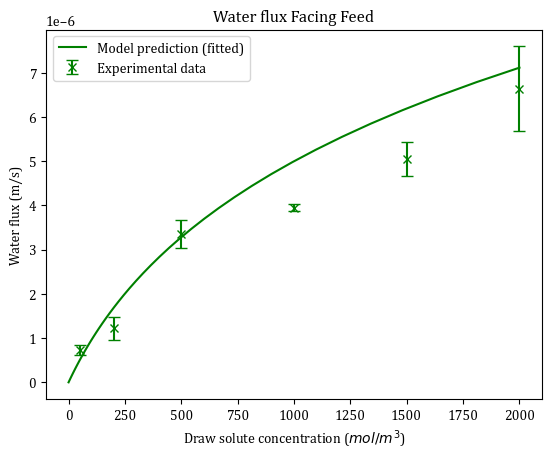

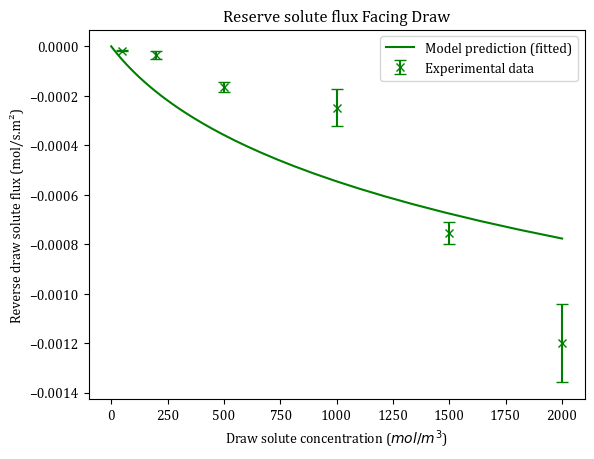

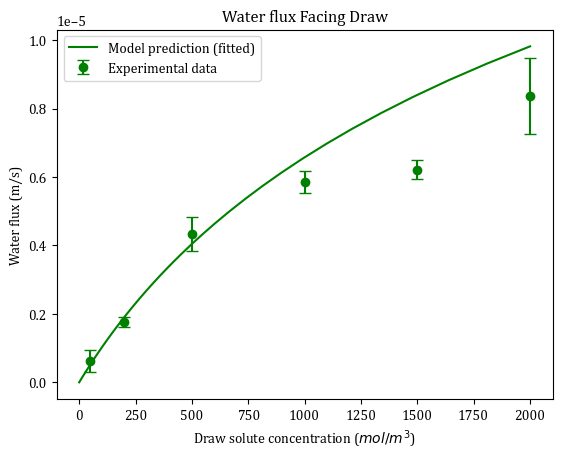

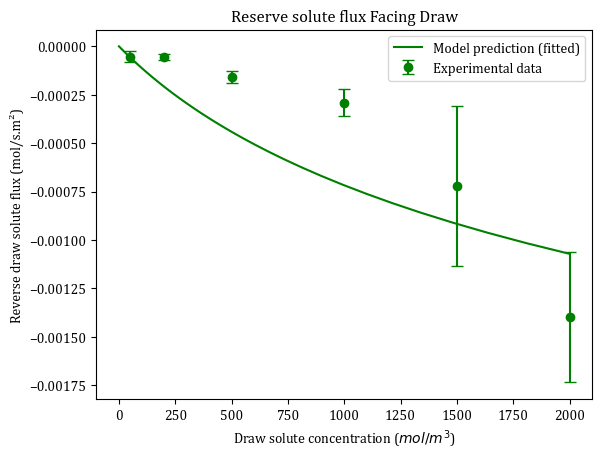

In [15]:
##   Method L-BFGS-B  – 

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize
import pandas  

# Osmotic pressure
def Pi(c):
    return 2*c*R*T

# Mass flux
def jf(J, c_Db, K, kM):
    PeDS=J/k_DS
    PeFS=J/k_FS
    PeM= J/kM
    Den= np.exp(PeFS) -1+(np.exp(PeM)-1)/(K * np.exp(PeM))+(np.exp(PeDS)-1)/(np.exp(PeDS)*np.exp(PeM))
    return J*(c_Fb*np.exp(PeFS)-c_Db*np.exp(-PeDS)*np.exp(-PeM))/Den

# Root equation
def cible(J,c_Db,K,kM,Lp):
    PeDS= J/k_DS
    PeFS= J/k_FS
    j= jf(J, c_Db, K, kM)
    c_Fi= (c_Fb-j/J)*np.exp(PeFS)+j /J   
    c_Di= (c_Db-j/J)*np.exp(-PeDS)+j/J  
    return J*1e10-1e10*(deltaP-Pi(c_Fi)+Pi(c_Di))*1e-15*Lp / mu

# Facing Feed calcultation 
def FF(c_Db,K,kM,Lp):
    global k_FS, k_DS
    k_DS= 1/(d_DS/(Sh_DS*D)+deltaSL/D)
    k_FS= Sh_FS*D/d_FS
    J0= (deltaP-(Pi(c_Fb)-Pi(c_Db)))*1e-15*Lp/mu
    J_FF= fsolve(cible, J0/10000, args=(c_Db, K, kM, Lp))[0]
    j_FF=jf(J_FF, c_Db, K, kM)
    return J_FF, j_FF

# Facing Draw calcultation 
def FD(c_Db, K, kM, Lp):
    global k_FS, k_DS
    k_FS = 1/(d_FS/(Sh_FS*D)+deltaSL/D)
    k_DS = Sh_DS*D/d_DS
    J0 = (deltaP-(Pi(c_Fb)-Pi(c_Db)))*1e-15*Lp/mu
    J_FD= fsolve(cible, J0 / 10000, args=(c_Db, K, kM,Lp))[0]
    j_FD= jf(J_FD,c_Db, K, kM)

    return J_FD, j_FD

##Name the colomn from the excel file
c_Db_exp= data["C"]
JFF100_ex= data["JwFF"]
err1 = data["JwFF_err"]
jFF100_ex = data["JsFF"]
err2 = data["JsFF_err"]
JFD100_ex = data["JwFD"]
err3  = data["JwFD_err"]
jFD100_ex = data["JsFD"]
err4 = data["JsFD_err"]
MNACL = 58.44

# Conversions
JFF100_exp= JFF100_ex * 1e-3 / 3600
err1_exp = err1 * 1e-3/3600
jFF100_exp= -jFF100_ex/(3600*MNACL)
err2_exp=  err2/ (3600*MNACL)
JFD100_exp= JFD100_ex*1e-3/3600
err3_exp= err3* 1e-3/3600

jFD100_exp= -jFD100_ex/(3600*MNACL)
err4_exp= err4/(3600*MNACL)


def gap(x):
    global Sh_DS, Sh_FS

    K = x[0]
    kM  = x[1]
    Lp  = x[2]
    JFFgap = 0
    jFFgap = 0
    JFDgap = 0
    jFDgap = 0
    for i in range(len(c_Db_exp)):
        Re = 100
        Sh_DS = 1.86*(Re*Sc*d_DS/L)**0.33
        Sh_FS = 1.86*(Re*Sc*d_FS/L)**0.33
        JFFgap += (JFF100_exp[i]-FF(c_Db_exp[i],K,kM,Lp)[0])**2
        jFFgap += (jFF100_exp[i]-FF(c_Db_exp[i],K,kM,Lp)[1])**2
        JFDgap += (JFD100_exp[i]-FD(c_Db_exp[i],K,kM,Lp)[0])**2
        jFDgap += (jFD100_exp[i]-FD(c_Db_exp[i],K,kM,Lp)[1])**2

    return 1e6*(1e4*JFFgap+jFFgap)+1e6*(1e4*JFDgap+jFDgap)

# Fitting 
x0 = np.array([1e-5, 0.017, 3])

res = minimize(gap,x0,method="L-BFGS-B",bounds=((1e-5, 2), (1e-5, 2), (0.01, 10)),options={"ftol":1e-12, "gtol":1e-8, "maxiter":10000})
print(res)
print("Fit:K =",res.x[0], "kM =",res.x[1], "Lp =", res.x[2]*1e-15,
      " m", res.x[2]*1e-15*1000*3600*1e5/mu, " LMH/bar" )

# Plots 
nbp = 100
c_Db_plt=np.logspace(np.log10(0.1),np.log10(2000),nbp)

J_FF_fit_plt=np.zeros(nbp)
j_FF_fit_plt=np.zeros(nbp)
J_FD_fit_plt=np.zeros(nbp)
j_FD_fit_plt=np.zeros(nbp)

Re=100
Sh_DS=1.86*(Re*Sc*d_DS/L)**0.33
Sh_FS=1.86*(Re*Sc*d_FS/L)**0.33

for i in range(nbp):
    J_FF_fit_plt[i], j_FF_fit_plt[i] = FF(c_Db_plt[i],*res.x)
    J_FD_fit_plt[i], j_FD_fit_plt[i] = FD(c_Db_plt[i],*res.x)

# Results for Facing Feed Mode 
plt.errorbar(c_Db_exp, JFF100_exp, yerr=err1_exp, fmt='gx',capsize=4,label="Experimental data")
plt.plot(c_Db_plt, J_FF_fit_plt, 'g-',label="Model prediction (fitted)")
plt.ylabel("Water flux (m/s)")
plt.xlabel("Draw solute concentration ($mol/m^3$)")
plt.title("Water flux Facing Feed")
plt.legend()
plt.show()

plt.errorbar(c_Db_exp, jFF100_exp, yerr=err2_exp, fmt='gx',capsize=4,label="Experimental data")
plt.plot(c_Db_plt, j_FF_fit_plt, 'g-',label="Model prediction (fitted)")
plt.ylabel("Reverse draw solute flux (mol/s.m²)")
plt.xlabel("Draw solute concentration ($mol/m^3$)")
plt.title("Reserve solute flux Facing Draw")
plt.legend()
plt.show()

# Results for Facing Draw Mode 
plt.errorbar(c_Db_exp, JFD100_exp, yerr=err3_exp, fmt='go',capsize=4, label="Experimental data")
plt.plot(c_Db_plt, J_FD_fit_plt, 'g-',label="Model prediction (fitted)")
plt.ylabel("Water flux (m/s)")
plt.xlabel("Draw solute concentration ($mol/m^3$)")
plt.title("Water flux Facing Draw")
plt.legend()
plt.show()

plt.errorbar(c_Db_exp, jFD100_exp, yerr=err4_exp, fmt='go',capsize=4, label="Experimental data")
plt.plot(c_Db_plt, j_FD_fit_plt, 'g-',label="Model prediction (fitted)" )
plt.ylabel("Reverse draw solute flux (mol/s.m²)") 
plt.xlabel("Draw solute concentration ($mol/m^3$)")
plt.title("Reserve solute flux Facing Draw")
plt.legend()
plt.show()
